# AI to Optimize Recruitment — Predicting Candidate Approval

This notebook was developed as part of a machine learning project aimed at optimizing the recruitment and selection process in tech companies. The goal is to use predictive models to automatically rank candidates with a higher probability of approval, reducing the manual effort of screening teams and increasing the process efficiency.


### Business Context

If the company uses this model to prioritize interviews or allocations, correctly identifying even half of the approved candidates is already a huge win. In processes with hundreds or thousands of applicants, this represents massive time savings—while ensuring top talent doesn't go unnoticed.

### Objectives

- Transform historical data into a model-ready dataset
- Handle class imbalance (few approved candidates)
- Test supervised models: Random Forest, XGBoost, Logistic Regression
- Rank candidates based on approval probability
- Measure real-world ranking performance (e.g. Top 100)

### Imports

In [85]:
import numpy as np
import pandas as pd
import logging
import joblib
import os
from datetime import datetime
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve, auc
)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


### Feature Selection & Data Preparation

#### Removing Highly Correlated Features

To avoid redundancy and reduce overfitting, we remove features with correlation above 0.90.

In [86]:
def remove_high_correlation(df, threshold=0.9):
    correlation_matrix = df.corr()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    drop_cols = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    df = df.drop(columns=drop_cols)
    logging.info(f"Removed {len(drop_cols)} highly correlated features: {drop_cols}")
    return df

#### Preparing ML Input

Convert the dataframe into a sequence-based input (if needed), and separate features from the target.


In [87]:
def prepare_ml_data(df, sequence_length, target_column):
    data = df.drop(columns=[target_column]).values
    target = df[target_column].values
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

### Model Classes

#### ML Models: RandomForest, XGBoost and Logistic Regression

Each model is encapsulated in its own class. All inherit from `BaseModel` to maintain consistency.


In [88]:
class BaseModel:
    def train(self, X_train, y_train): pass
    def predict(self, X_test): pass
    def predict_proba(self, X_test): pass
    
    def evaluate(self, y_test, predictions):
        return {
            "accuracy": accuracy_score(y_test, predictions),
            "precision": precision_score(y_test, predictions),
            "recall": recall_score(y_test, predictions),
            "f1_score": f1_score(y_test, predictions),
            "confusion_matrix": confusion_matrix(y_test, predictions)
        }

class RandomForestModel(BaseModel):
    def __init__(self):
        self.model = RandomForestClassifier(n_estimators=100, class_weight='balanced')

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)

class XGBoostModel(BaseModel):
    def __init__(self, scale_pos_weight=1):
        self.model = xgb.XGBClassifier(
            objective='binary:logistic',
            n_estimators=200,
            learning_rate=0.05,
            eval_metric='logloss',
            scale_pos_weight=scale_pos_weight
        )

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)

class LogisticRegressionModel(BaseModel):
    def __init__(self):
        self.model = LogisticRegression(max_iter=1000, class_weight='balanced')

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)

### Pipeline and Evaluation

#### Model Training and Evaluation Pipeline

This function runs the entire training + evaluation pipeline for each model, including:
- train/test split
- ROC-AUC evaluation
- candidate ranking simulation


In [89]:
def plot_precision_at_k(ranked_candidates, max_k=1000):
    precisions = []
    ks = range(1, max_k + 1)
    aprovados = ranked_candidates['approved'].values

    for k in ks:
        precisions.append(np.sum(aprovados[:k]) / k)

    plt.figure(figsize=(10, 5))
    plt.plot(ks, precisions, label='Precision@K', color='blue')
    plt.axhline(y=ranked_candidates['approved'].mean(), color='gray', linestyle='--', label='Base approval rate')
    plt.xlabel('Top K ranked candidates')
    plt.ylabel('Precision@K')
    plt.title('Ranking Effectiveness')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_roc_curve(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {float(roc_auc):.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def run_pipeline(models, df, target_column, sequence_length=10, plot_metrics=False):
    X, y = prepare_ml_data(df, sequence_length, target_column)
    X = X.reshape(X.shape[0], -1)

    df = df.iloc[-X.shape[0]:].copy()
    X = pd.DataFrame(X, index=df.index)
    y = pd.Series(y, index=df.index)

    X['original_index'] = df.index

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True, random_state=42
    )

    X_train_index = X_train['original_index']
    X_test_index = X_test['original_index']
    X_train = X_train.drop('original_index', axis=1)
    X_test = X_test.drop('original_index', axis=1)

    best_model = None
    best_score = 0

    for model in models:
        model.train(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)

        positive_class_proba = y_pred_proba[:, 1] if len(y_pred_proba.shape) > 1 else y_pred_proba
        roc_auc = roc_auc_score(y_test, positive_class_proba)
        logging.info(f"{model.__class__.__name__} ROC-AUC: {roc_auc:.4f}")

        if roc_auc > best_score:
            best_score = roc_auc
            best_model = model

        if plot_metrics:
            plot_roc_curve(y_test, positive_class_proba, model.__class__.__name__)

        ranked_candidates = pd.DataFrame({
            'candidate_id': X_test_index,
            'approval_probability': positive_class_proba,
            'approved': y_test.values
        }).sort_values(by='approval_probability', ascending=False)

        top_100 = ranked_candidates.head(100)
        approved_top_100 = top_100['approved'].sum()
        logging.info(f"{model.__class__.__name__} - Approved in Top 100: {approved_top_100}")
        plot_precision_at_k(ranked_candidates)


    return best_model, X_train

#### Model Saving

In [90]:
def save_model(model, model_name, models_dir):
    joblib.dump(model.model, os.path.join(models_dir, f"{model_name}.joblib"))

#### Main Function and Execution

INFO:root:Removed 3 highly correlated features: ['candidate_english_level_Nao informado', 'candidate_spanish_level_Nao informado', 'candidate_pcd_Nao informado']
INFO:root:=== Starting pipeline ===
INFO:root:RandomForestModel ROC-AUC: 0.6541


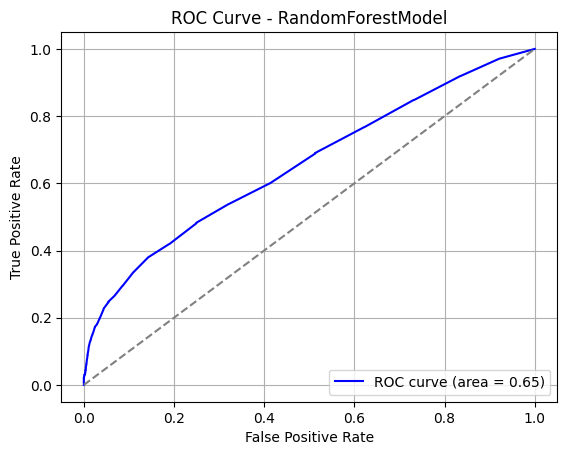

INFO:root:RandomForestModel - Approved in Top 100: 39


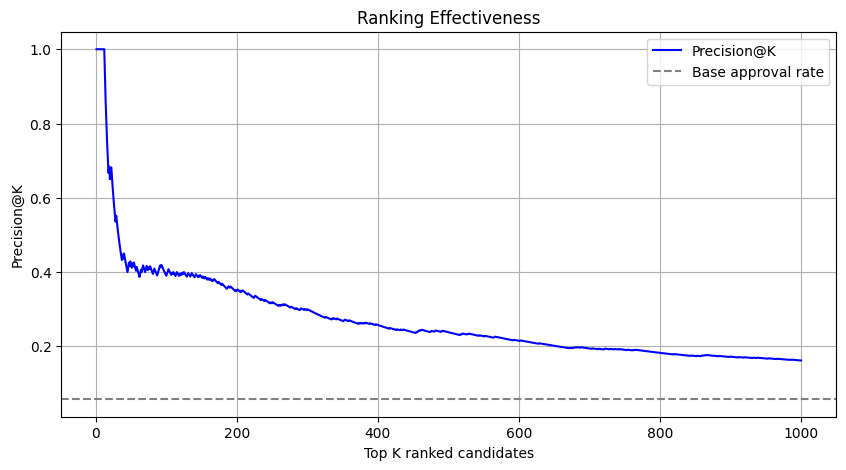

INFO:root:XGBoostModel ROC-AUC: 0.6706


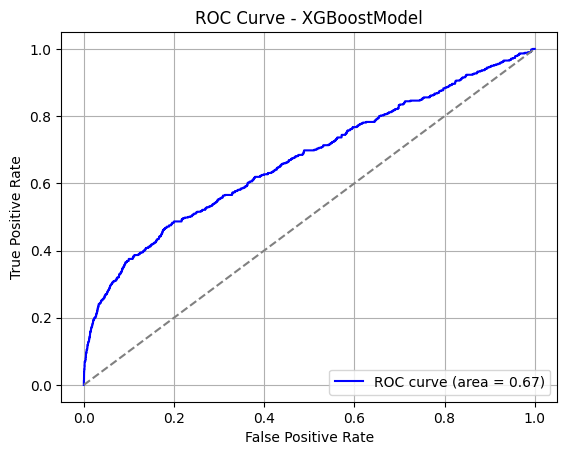

INFO:root:XGBoostModel - Approved in Top 100: 51


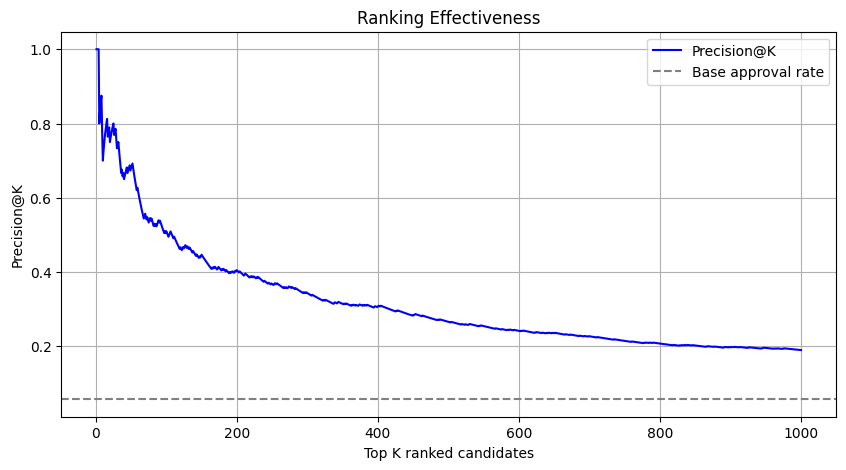

INFO:root:LogisticRegressionModel ROC-AUC: 0.6438


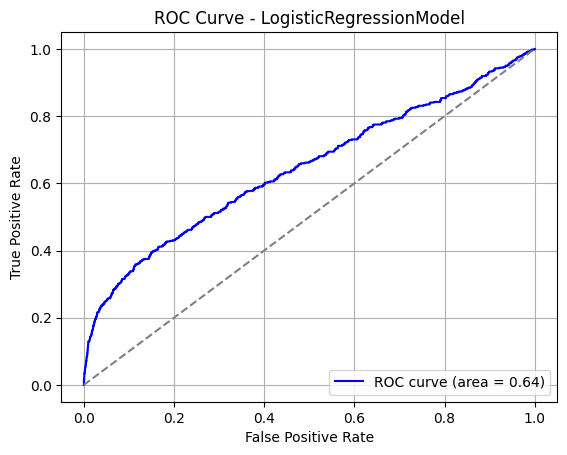

INFO:root:LogisticRegressionModel - Approved in Top 100: 44


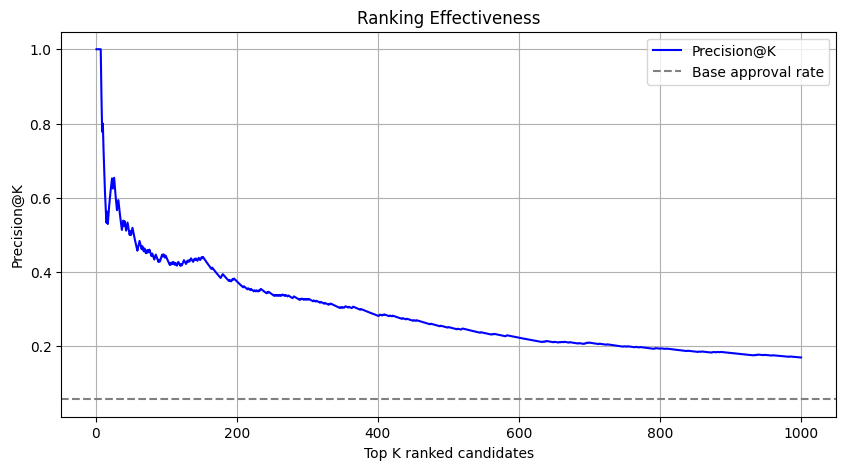

INFO:root:Model saved: XGBoostModel


In [91]:
def main():
    df = pd.read_csv('../data/encoded/df_encoded.csv')
    target_column = 'prospect_candidate_status_Aprovado'
    df = remove_high_correlation(df)

    count_pos = df[target_column].sum()
    count_neg = len(df) - count_pos
    scale_pos_weight = count_neg / count_pos

    models = [
        RandomForestModel(),
        XGBoostModel(scale_pos_weight=scale_pos_weight),
        LogisticRegressionModel()
    ]

    logging.info("=== Starting pipeline ===")
    best_model, X_train = run_pipeline(models, df, target_column, plot_metrics=True)

    if best_model:
        model_name = best_model.__class__.__name__
        models_dir = os.path.join(os.path.abspath(os.path.pardir), 'models')
        os.makedirs(models_dir, exist_ok=True)
        save_model(best_model, model_name, models_dir)
        logging.info(f"Model saved: {model_name}")

if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)
    main()


#### Insight

- **Top 100 candidates**: 51% were actually approved → **10x better than random** (base rate ~5%).
- **Top 1000 candidates**: 15% approval rate → **3x better than random**.

#### Impact

This model acts as a recommendation engine for recruiters:
- Focus efforts on high-potential profiles
- Reduce time spent on non-qualifying candidates
- Improve hiring rate with less manual screening

Even in its initial version, the model provides a solid filtering mechanism and can evolve with feedback from recruiters and historical outcomes.
